In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import sys
import os

sys.path.insert(0, os.path.abspath("../../.."))
sys.path.insert(0, os.path.abspath("../"))
sys.path.append(os.path.abspath("../../../backend"))
sys.path.append(os.path.abspath(""))

from sqlalchemy.orm import aliased, joinedload, selectinload, contains_eager
from sqlalchemy import text
from rdflib.plugins.stores.sparqlstore import SPARQLStore
from backend.model import (
    DeclarativeBase,
    Session,
)

from backend.ontology import OntologyManager, OntologyConfig, Graph
from backend.explorative_support import TopicModelling, select
from backend.llm_query import (
    Entity,
    Relation,
    EntitiesRelations,
    EnrichedEntity,
    EnrichedRelation,
    EnrichedEntitiesRelations,
    SubjectLink,
    SubjectInDB,
    SubjectLinkDB,
)
from tqdm import tqdm
import pandas as pd
import numpy as np
store = SPARQLStore(
    "http://localhost:7012/",
    method="POST_FORM",
    params={"infer": False, "sameAs": False},
)
graph = Graph(store=store)

config = OntologyConfig()

ontology_manager = OntologyManager(config, graph)
topic_man = TopicModelling(ontology_manager)

In [4]:
top_k = 100
seed = 42

In [24]:
from query_gen import EnrichedDBEntity, EnrichedDBRelation

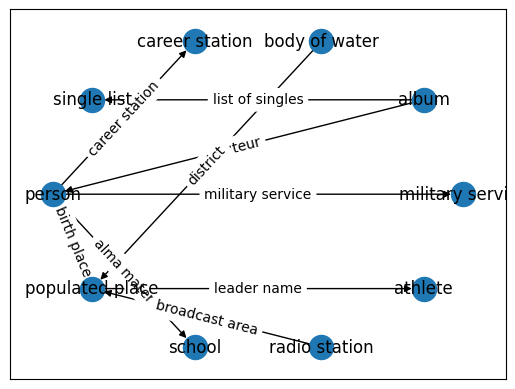

In [6]:
import networkx as nx


def viz_graph(erl: EnrichedEntitiesRelations):
    G = nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity, link.target, weight=link.link.instance_count, label=link.relation
        )
    pos = nx.shell_layout(G)
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        labels={node.identifier: node.type for node in erl.entities},
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(link.entity, link.target): link.relation for link in erl.relations}
    )
    return G


viz_graph(erl)

In [ ]:
csvs_to_fix = ["examples_DBpedia.csv", "examples_DBpedia_human.csv"]
for csv in csvs_to_fix:
    existing_examples = pd.read_csv(f"old_{csv}", index_col=0)
    existing_examples["erl_model"] = existing_examples["erl"].apply(
        lambda x: EnrichedEntitiesRelations.model_validate_json(x, strict=False)
    )
    existing_examples.to_csv(csv)

    with Session(topic_man.engine) as session:
        for example in tqdm(existing_examples["erl_model"], desc="Fixing examples"):
            example: EnrichedEntitiesRelations = example
            for rel in example.relations:
                rel_db = (
                    session.query(SubjectLinkDB)
                    .filter(SubjectLinkDB.label == rel.relation)
                    .first()
                )
                if rel_db is None:
                    print(f"Relation {rel.relation} not found in DB")
                    continue
                rel.link = SubjectLink.from_db(rel_db, oman=ontology_manager)

        existing_examples["erl"] = existing_examples["erl_model"].apply(
            lambda x: x.model_dump_json()
        )
        existing_examples = existing_examples.drop(columns="erl_model")
        existing_examples.to_csv(csv)

Fixing examples: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
